# DR CI for Comparing Abstaining Classifiers under MAR

Experiment 1.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
from collections import OrderedDict

import comparecast as cc
import comparecast_causal as c3

[MLENS] backend: threading


In [2]:
RANDOM_SEED = 1234

rng = np.random.default_rng(RANDOM_SEED)

Configurations for evaluation:

In [3]:
ALPHA = 0.05
SCORING_RULE = "zero_one"
EPSILON = 0.2
CLIP_PI = EPSILON  # how much to clip large values of estimated abstention probability
N_TRIALS = 1000     # repetitions  
N_JOBS = -1         # number of CPU cores for parallel processing
MIXED_EST = False   # use mixed estimation

In [4]:
PLOTS_DIR = "./plots/binary_mar/experiment1/final_plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

FONT = "Avenir"
FONT_SCALE = 2.0
# FONT = "Liberation Serif"  # for servers & colab; if not use "DejaVu Serif"
cc.set_theme(style="whitegrid", font=FONT, font_scale=FONT_SCALE)

In [5]:
palette = sns.color_palette("colorblind")
palette

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [6]:
valid_markers = [',', '.', 'o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']

## Data

Generate synthetic predictions and abstentions.

In [7]:
n = 2000
epsilon = EPSILON        # positivity level
threshold = 0.2          # how close to border do you switch to abstention?
noise_level = 0.15       # noise level of the true decision boundary
threshold_b_mult = 1.25  # width of the "cautiousness" region for B, relative to A's
print_fraction = 0.25    # how much of the data points to actually print in the plot 

data = c3.data_utils.abstaining_classifiers.generate_binary_mar(
    n=n, 
    epsilon=epsilon,
    threshold=threshold,
    noise_level=noise_level,
    is_comparison=True,
    threshold_b_mult=threshold_b_mult,
    rng=rng,
    for_plotting=True,
)
data["Classifier"].replace({"A": "A [Optimal]", "B": "B [Biased]"}, inplace=True)
data.rename(columns={"Correct": "Correct?", "Abstain": "Abstain?"}, inplace=True)
data

,$X_0$,$X_1$,$Y$,Classifier,$P$,$\hat{Y}$,Abstain?,Correct?
0,0.976700,0.380196,1,A [Optimal],0.588289,1,No,Yes
1,0.923246,0.261692,1,A [Optimal],0.546103,1,Yes,Yes
2,0.319097,0.118091,0,A [Optimal],0.362897,0,Yes,Yes
3,0.241766,0.318534,0,A [Optimal],0.391813,0,No,Yes
4,0.964079,0.263650,1,A [Optimal],0.556687,1,No,Yes
...,...,...,...,...,...,...,...,...
3995,0.447085,0.572443,1,B [Biased],0.363788,0,No,No
3996,0.785321,0.039024,0,B [Biased],0.409126,0,Yes,Yes
3997,0.484321,0.654514,1,B [Biased],0.431478,0,Yes,No
3998,0.219913,0.875807,1,B [Biased],0.507700,1,Yes,Yes


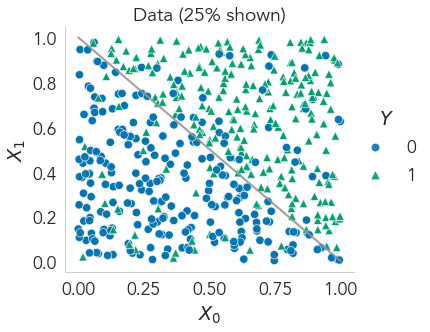

In [8]:
n_print = int(print_fraction * n)
print_index = np.r_[np.arange(n_print), np.arange(n, n + n_print)]

fg = sns.relplot(
    x=r"$X_0$",
    y=r"$X_1$",
    # colors
    hue=r"$Y$",
    palette=[palette[0], palette[2]],
    # markers
    style=r"$Y$",
    style_order=[0, 1],
    markers=['o', '^'],
    alpha=0.9,
    data=data.iloc[print_index],
    aspect=1.1,
    s=70,
    color="black",
)
for ax in fg.axes[0]:
    ax.grid()

x0 = np.linspace(0, 1, 100)
# A boundary
x1_a = 1 - x0
fg.axes[0, 0].plot(x0, x1_a, linewidth=2, alpha=0.9, color=palette[7])
fg.axes[0, 0].set_title("Data ({:g}% shown)".format(100 * print_fraction))
# legend setups
sns.move_legend(fg, "center right", bbox_to_anchor=(0.95, 0.55))
for lh in fg._legend.legendHandles: 
    lh.set_alpha(0.9)
    lh._sizes = [50] 
fg.tight_layout()
fg.savefig(os.path.join(PLOTS_DIR, "data.pdf"))
None

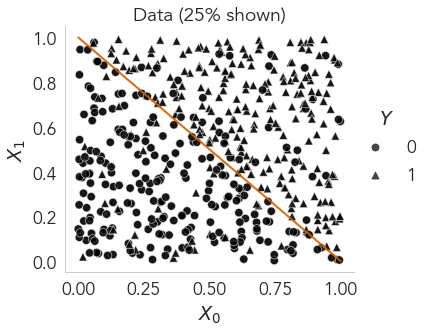

In [9]:
# shapes
n_print = int(print_fraction * n)
print_index = np.r_[np.arange(n_print), np.arange(n, n + n_print)]

fg = sns.relplot(
    x=r"$X_0$",
    y=r"$X_1$",
    # colors
#     hue=r"$Y$",
#     palette=[palette[0], palette[3]],
    # markers
    style=r"$Y$",
    style_order=[0, 1],
    markers=['o', '^'],
    alpha=0.7,
    data=data.iloc[print_index],
    aspect=1.1,
    s=70,
    color="black",
)
for ax in fg.axes[0]:
    ax.grid()

x0 = np.linspace(0, 1, 100)
# A boundary
x1_a = 1 - x0
fg.axes[0, 0].plot(x0, x1_a, linewidth=2, alpha=0.9, color=palette[3])
fg.axes[0, 0].set_title("Data ({:g}% shown)".format(100 * print_fraction))
# legend setups
sns.move_legend(fg, "center right", bbox_to_anchor=(0.95, 0.55))
for lh in fg._legend.legendHandles: 
    lh.set_alpha(0.9)
    lh._sizes = [50] 
fg.tight_layout()
fg.savefig(os.path.join(PLOTS_DIR, "data_alt.pdf"))
None

## Classifier Pairs (Main)

### V1: abstention & correctness

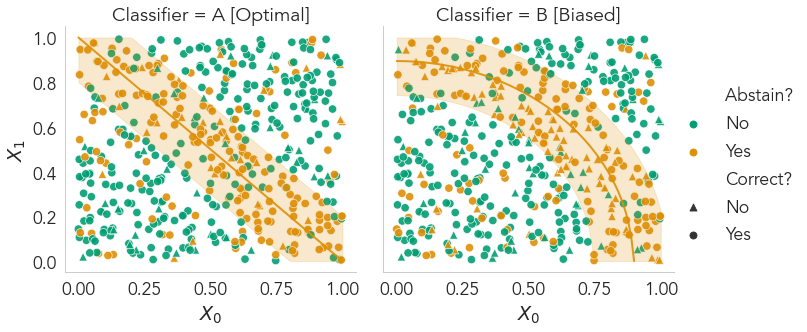

In [10]:
colors = {
    "predict": palette[2],
    "abstain": palette[1],
    "boundary": palette[1],
}

fg = sns.relplot(
    x=r"$X_0$",
    y=r"$X_1$",
    col="Classifier",
    # colors
    hue="Abstain?",
    hue_order=["No", "Yes"],
    palette=[colors["predict"], colors["abstain"]],
#     hue=r"$Y$",
#     hue_order=[0, 1],
#     palette=[palette[0], palette[2]],
    alpha=0.9,
    # markers
    style="Correct?",
    style_order=["No", "Yes"],
    markers=['^', 'o'],
    data=data.iloc[print_index],
    s=70,
)
for ax in fg.axes[0]:
    ax.grid()

x0 = np.linspace(0, 1, 100)

# A boundary & abstention regions
x1_a = 1 - x0
fg.axes[0, 0].plot(x0, x1_a, linewidth=2, alpha=0.9, color=colors["boundary"])
thres_a = threshold
fg.axes[0, 0].fill_between(
    x=x0,
    y1=np.maximum(0, x1_a - thres_a),
    y2=np.minimum(1, x1_a + thres_a),
    alpha=0.2,
    color=colors["boundary"],
)

# B boundary & abstention regions
x1_b = np.sqrt(np.maximum(0, 0.8 - x0 ** 2))
mask_b = x0 <= np.sqrt(0.81)
fg.axes[0, 1].plot(x0[mask_b], x1_b[mask_b], 
                   linewidth=2, alpha=0.9, color=colors["boundary"])
thres_b = threshold_b_mult * threshold
fg.axes[0, 1].fill_between(
    x=x0,
    y1=np.maximum(0, np.sqrt(np.maximum(0, 0.8 - thres_b - x0 ** 2))),
    y2=np.minimum(1, np.sqrt(np.maximum(0, 0.8 + thres_b - x0 ** 2))),
    alpha=0.2,
    color=colors["boundary"],
)

# legend setup
sns.move_legend(fg, "center right", bbox_to_anchor=(1.0, 0.5))
for lh in fg._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [50] 
fg.tight_layout()
fg.savefig(os.path.join(PLOTS_DIR, "classifiers_alt1.pdf"))
None

### V2: abstention & outcomes

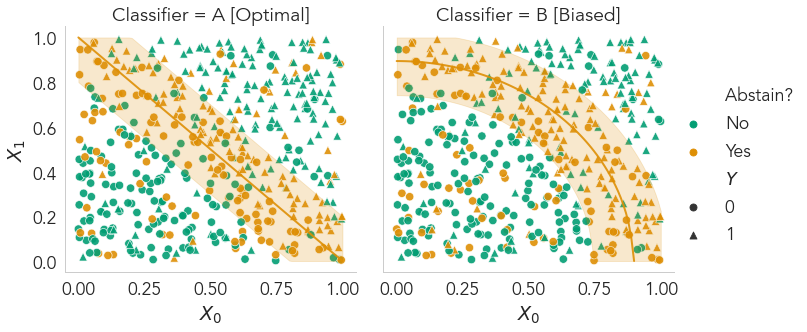

In [11]:
colors = {
    "predict": palette[2],
    "abstain": palette[1],
    "boundary": palette[1],
}

fg = sns.relplot(
    x=r"$X_0$",
    y=r"$X_1$",
    col="Classifier",
    # colors
    hue=r"Abstain?",
    hue_order=["No", "Yes"],
    palette=[colors["predict"], colors["abstain"]],
    alpha=0.9,
    # markers
    style=r"$Y$",
    style_order=[0, 1],
    markers=['o', '^'],
    data=data.iloc[print_index],
    s=70,
)
for ax in fg.axes[0]:
    ax.grid()

x0 = np.linspace(0, 1, 100)

# A boundary & abstention regions
x1_a = 1 - x0
fg.axes[0, 0].plot(x0, x1_a, linewidth=2, alpha=0.9, color=colors["boundary"])
thres_a = threshold
fg.axes[0, 0].fill_between(
    x=x0,
    y1=np.maximum(0, x1_a - thres_a),
    y2=np.minimum(1, x1_a + thres_a),
    alpha=0.2,
    color=colors["boundary"],
)

# B boundary & abstention regions
x1_b = np.sqrt(np.maximum(0, 0.8 - x0 ** 2))
mask_b = x0 <= np.sqrt(0.81)
fg.axes[0, 1].plot(x0[mask_b], x1_b[mask_b], 
                   linewidth=2, alpha=0.9, color=colors["boundary"])
thres_b = threshold_b_mult * threshold
fg.axes[0, 1].fill_between(
    x=x0,
    y1=np.maximum(0, np.sqrt(np.maximum(0, 0.8 - thres_b - x0 ** 2))),
    y2=np.minimum(1, np.sqrt(np.maximum(0, 0.8 + thres_b - x0 ** 2))),
    alpha=0.2,
    color=colors["boundary"],
)

# legend setup
sns.move_legend(fg, "center right", bbox_to_anchor=(1.0, 0.5))
for lh in fg._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [50] 
fg.tight_layout()
fg.savefig(os.path.join(PLOTS_DIR, "classifiers_alt2.pdf"))
None

### V3: pred1-abstain-pred0

In [12]:
data["Prediction"] = np.where(data["Abstain?"] == "Yes", "Abst.", data[r"$\hat{Y}$"])

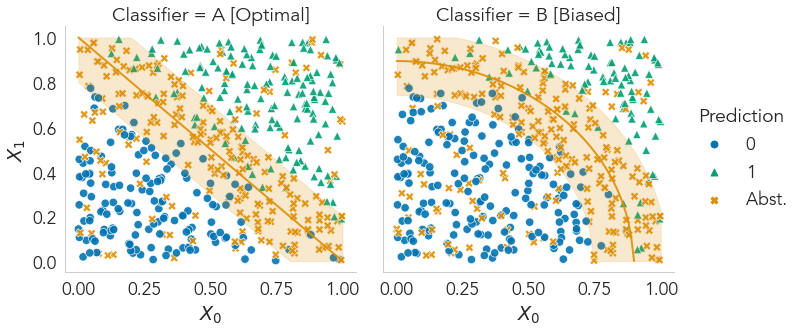

In [13]:
colors = {
    "predict_0": palette[0],
    "predict_1": palette[2],
    "abstain": palette[1],
    "boundary": palette[1],
}

fg = sns.relplot(
    x=r"$X_0$",
    y=r"$X_1$",
    col="Classifier",
    # colors
    hue="Prediction",
    hue_order=["0", "1", "Abst."],
    palette=[colors["predict_0"], colors["predict_1"], colors["abstain"]],
    alpha=0.9,
    # markers
    style="Prediction",
    style_order=["0", "1", "Abst."],
    markers=['o', '^', 'X'],
#     style=r"$Y$",
#     style_order=[0, 1],
#     markers=['o', '^'],
    data=data.iloc[print_index],
    s=70,
)
for ax in fg.axes[0]:
    ax.grid()

x0 = np.linspace(0, 1, 100)

# A boundary & abstention regions
x1_a = 1 - x0
fg.axes[0, 0].plot(x0, x1_a, linewidth=2, alpha=0.9, color=colors["boundary"])
thres_a = threshold
fg.axes[0, 0].fill_between(
    x=x0,
    y1=np.maximum(0, x1_a - thres_a),
    y2=np.minimum(1, x1_a + thres_a),
    alpha=0.2,
    color=colors["boundary"],
)

# B boundary & abstention regions
x1_b = np.sqrt(np.maximum(0, 0.8 - x0 ** 2))
mask_b = x0 <= np.sqrt(0.81)
fg.axes[0, 1].plot(x0[mask_b], x1_b[mask_b], 
                   linewidth=2, alpha=0.9, color=colors["boundary"])
thres_b = threshold_b_mult * threshold
fg.axes[0, 1].fill_between(
    x=x0,
    y1=np.maximum(0, np.sqrt(np.maximum(0, 0.8 - thres_b - x0 ** 2))),
    y2=np.minimum(1, np.sqrt(np.maximum(0, 0.8 + thres_b - x0 ** 2))),
    alpha=0.2,
    color=colors["boundary"],
)

# legend setup
sns.move_legend(fg, "center right", bbox_to_anchor=(0.99, 0.52), frameon=False)
# sns.move_legend(fg, loc="lower center", bbox_to_anchor=(0.45, -0.15),
#                 frameon=True, ncol=4)
for lh in fg._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [50] 
fg.tight_layout()
fg.savefig(os.path.join(PLOTS_DIR, "classifiers.pdf"))
None

## Miscoverage Rates

Averaged over `n_trials`.

* Estimator choices: `Plugin`, `IPW`, `DR`
* Nuisance function learners: `Linear`, `RandomForest`, `SuperLearner`

In [14]:
estimators = ["Plugin", "IPW", "DR"]
learners = ["Linear", "RandomForest", "SuperLearner"]

In [15]:
miscov_df = pd.read_csv("plots/binary_mar/experiment1/zero_one/eps0.2/miscoverage.csv",
                        index_col=0)

In [16]:
# latex
print("Learner      & \t" + "\t\t & ".join(estimators))
for learner in learners:
    line = "{:12s}".format(learner)
    for estimator in estimators:
        mcs = miscov_df.loc[np.logical_and(miscov_df["Learner"] == learner, 
                                           miscov_df["Estimator"] == estimator), "Miscoverage"]
        m = np.mean(mcs)
        line += " & {:.3f} $\pm$ {:.3f}".format(m, np.sqrt(m * (1-m) / len(mcs)))
    line += " \\\\"
    print(line)
    
    line = "            "
    for estimator in estimators:
        ws = miscov_df.loc[np.logical_and(miscov_df["Learner"] == learner, 
                                          miscov_df["Estimator"] == estimator), "Width"]
        line += " & ({:.3f})\t\t".format(np.mean(ws))
    line += " \\\\"
    print(line)

Learner      & 	Plugin		 & IPW		 & DR
Linear       & 1.000 $\pm$ 0.000 & 0.756 $\pm$ 0.014 & 0.995 $\pm$ 0.002 \\
             & (0.002)		 & (0.090)		 & (0.043)		 \\
RandomForest & 0.641 $\pm$ 0.015 & 0.138 $\pm$ 0.011 & 0.054 $\pm$ 0.007 \\
             & (0.022)		 & (0.133)		 & (0.069)		 \\
SuperLearner & 0.906 $\pm$ 0.009 & 0.034 $\pm$ 0.006 & 0.047 $\pm$ 0.007 \\
             & (0.012)		 & (0.123)		 & (0.063)		 \\


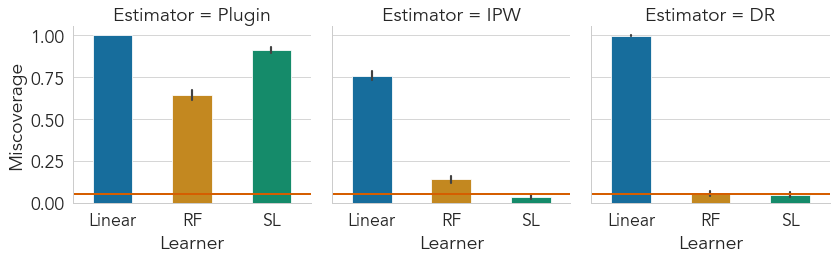

In [17]:
def bernoulli_ci(xs):
    m = xs.mean()
    se = np.sqrt(m * (1 - m) / len(xs))
    return max(0, m - 1.96 * se), min(1, m + 1.96 * se)


cc.set_theme(style="whitegrid", font=FONT, font_scale=FONT_SCALE)  # grid on
fg = sns.FacetGrid(miscov_df, col="Estimator", hue="Learner", height=4)
fg.map_dataframe(
    sns.barplot, x="Learner", y="Miscoverage", 
    order=learners, errorbar=bernoulli_ci, width=0.5,
)
for ax in fg.axes[0]:
    ax.axhline(ALPHA, linewidth=2, color=cc.get_color_by_index(3))
    ax.set_xticklabels(["Linear", "RF", "SL"])

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "miscoverage.pdf"))

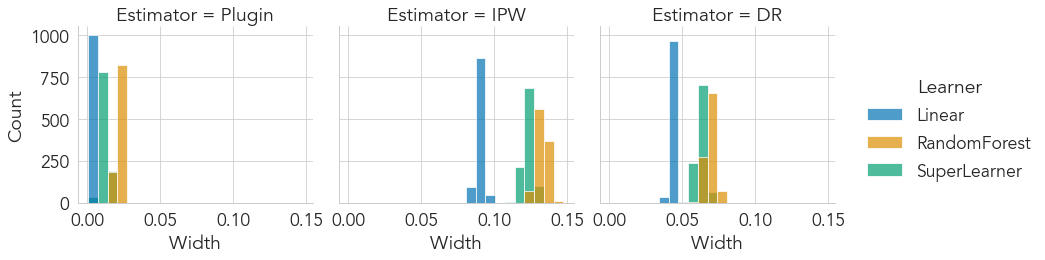

In [18]:
# RF can blow up
fg = sns.displot(
    x="Width",
    col="Estimator",
    hue="Learner",
    alpha=0.7,
    data=miscov_df,
    aspect=0.8,
    height=4,
)
sns.move_legend(fg, "center right", bbox_to_anchor=(1.22, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "width.pdf"))

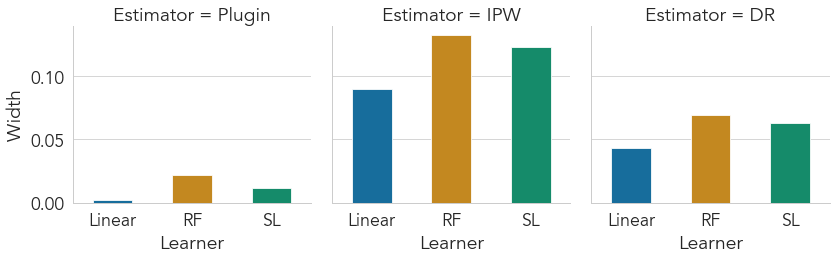

In [19]:
fg = sns.FacetGrid(miscov_df, col="Estimator", hue="Learner", height=4)
fg.map_dataframe(
    sns.barplot, x="Learner", y="Width", 
    order=learners, errorbar="ci", width=0.5,
)
for ax in fg.axes[0]:
    ax.set_xticklabels(["Linear", "RF", "SL"])
    #ax.set_yscale("log")

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "width_bar.pdf"))

## Positivity

In [20]:
positivity_df = pd.read_csv("./plots/binary_mar/experiment1/zero_one/eps0.2/miscoverage_by_positivity.csv",
                            index_col=0)

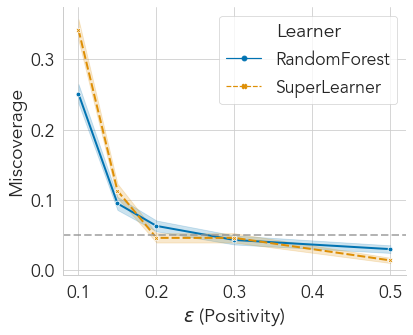

In [21]:
fg = sns.relplot(
    x="Epsilon",
    y="Miscoverage",
    hue="Learner",
    style="Learner",
    kind="line",
    linewidth=2,
    markers=True,
    errorbar="se",
    data=positivity_df.query("Learner != 'Linear'"),
    height=5,
    aspect=1.25,
    facet_kws={"legend_out": False},
)
fg.axes[0, 0].set_xlabel(r"$\epsilon$" + " (Positivity)")
fg.axes[0, 0].axhline(y=0.05, alpha=0.7, linewidth=2, linestyle="--",
                      color=cc.get_color_by_index(7))
# sns.move_legend(fg, "center", bbox_to_anchor=(0.45, 0.55))
fg.savefig(os.path.join(PLOTS_DIR, "miscoverage_by_positivity.pdf"))

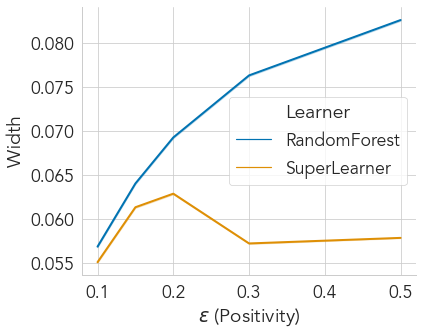

In [22]:
fg = sns.relplot(
    x="Epsilon",
    y="Width",
    hue="Learner",
    kind="line",
    linewidth=2,
    markers=True,
    errorbar="se",
    data=positivity_df.query("Learner != 'Linear'"),
    aspect=1.25,
    facet_kws={"legend_out": False},
)
fg.axes[0, 0].set_xlabel(r"$\epsilon$" + " (Positivity)")
fg.savefig(os.path.join(PLOTS_DIR, "width_by_positivity.pdf"))

## Classifier Pairs (for Power Experiment)

In [23]:
n = 2000
power_mu = 0.2           # how much the decision boundery gets shifted for B

data = c3.data_utils.abstaining_classifiers.generate_binary_mar(
    n=n, 
    epsilon=epsilon,
    threshold=threshold,
    noise_level=noise_level,
    is_power_analysis=True,
    power_mu=power_mu,
    rng=rng,
    for_plotting=True,
)
data = data.rename(columns={"Correct": "Correct?", "Abstain": "Abstain?"})
data["Classifier"].replace({"A": "A [Optimal]", "B": "B [Biased]"}, inplace=True)

### V1: abstention & correctness

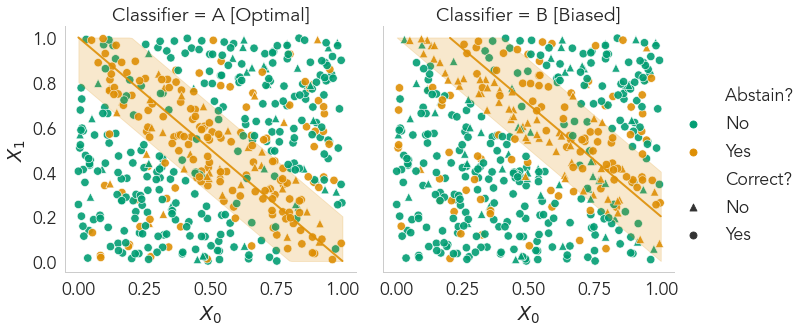

In [24]:
colors = {
    "predict": palette[2],
    "abstain": palette[1],
    "boundary": palette[1],
}

fg = sns.relplot(
    x=r"$X_0$",
    y=r"$X_1$",
    col="Classifier",
    # colors
    hue="Abstain?",
    hue_order=["No", "Yes"],
    palette=[colors["predict"], colors["abstain"]],
#     hue=r"$Y$",
#     hue_order=[0, 1],
#     palette=[palette[0], palette[2]],
    alpha=0.9,
    # markers
    style="Correct?",
    style_order=["No", "Yes"],
    markers=['^', 'o'],
    data=data.iloc[print_index],
    s=70,
)
for ax in fg.axes[0]:
    ax.grid()

x0 = np.linspace(0, 1, 100)

# A boundary & abstention regions
x1_a = 1 - x0
fg.axes[0, 0].plot(x0, x1_a, linewidth=2, alpha=0.9, color=colors["boundary"])
thres_a = threshold
fg.axes[0, 0].fill_between(
    x=x0,
    y1=np.maximum(0, x1_a - thres_a),
    y2=np.minimum(1, x1_a + thres_a),
    alpha=0.2,
    color=colors["boundary"],
)

# B boundary & abstention regions
x1_b = 1 + power_mu - x0
mask_b = x1_b <= 1
fg.axes[0, 1].plot(x0[mask_b], x1_b[mask_b], 
                   linewidth=2, alpha=0.9, color=colors["boundary"])
thres_b = threshold
fg.axes[0, 1].fill_between(
    x=x0,
    y1=np.maximum(0, x1_b - thres_b),
    y2=np.minimum(1, x1_b + thres_b),
    alpha=0.2,
    color=colors["boundary"],
)


# legend setup
sns.move_legend(fg, "center right", bbox_to_anchor=(1.0, 0.5))
for lh in fg._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [50] 
fg.tight_layout()
fg.savefig(os.path.join(PLOTS_DIR, "classifiers_power_alt1.pdf"))
None

### V2: abstention & outcomes

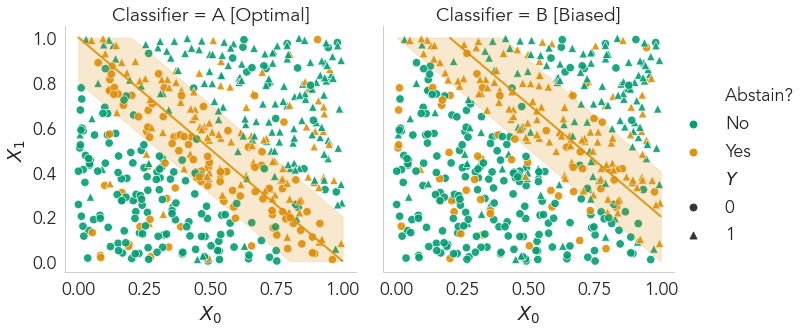

In [25]:
colors = {
    "predict": palette[2],
    "abstain": palette[1],
    "boundary": palette[1],
}

fg = sns.relplot(
    x=r"$X_0$",
    y=r"$X_1$",
    col="Classifier",
    # colors
    hue="Abstain?",
    hue_order=["No", "Yes"],
    palette=[colors["predict"], colors["abstain"]],
    alpha=0.9,
    # markers
    style=r"$Y$",
    style_order=[0, 1],
    markers=['o', '^'],
    data=data.iloc[print_index],
    s=70,
)
for ax in fg.axes[0]:
    ax.grid()

x0 = np.linspace(0, 1, 100)

# A boundary & abstention regions
x1_a = 1 - x0
fg.axes[0, 0].plot(x0, x1_a, linewidth=2, alpha=0.9, color=colors["boundary"])
thres_a = threshold
fg.axes[0, 0].fill_between(
    x=x0,
    y1=np.maximum(0, x1_a - thres_a),
    y2=np.minimum(1, x1_a + thres_a),
    alpha=0.2,
    color=colors["boundary"],
)

# B boundary & abstention regions
x1_b = 1 + power_mu - x0
mask_b = x1_b <= 1
fg.axes[0, 1].plot(x0[mask_b], x1_b[mask_b], 
                   linewidth=2, alpha=0.9, color=colors["boundary"])
thres_b = threshold
fg.axes[0, 1].fill_between(
    x=x0,
    y1=np.maximum(0, x1_b - thres_b),
    y2=np.minimum(1, x1_b + thres_b),
    alpha=0.2,
    color=colors["boundary"],
)


# legend setup
sns.move_legend(fg, "center right", bbox_to_anchor=(1.0, 0.5))
for lh in fg._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [50] 
fg.tight_layout()
fg.savefig(os.path.join(PLOTS_DIR, "classifiers_power_alt2.pdf"))
None

### V3: 1 column

In [26]:
data["Prediction"] = np.where(data["Abstain?"] == "Yes", "Abst.", data[r"$\hat{Y}$"])

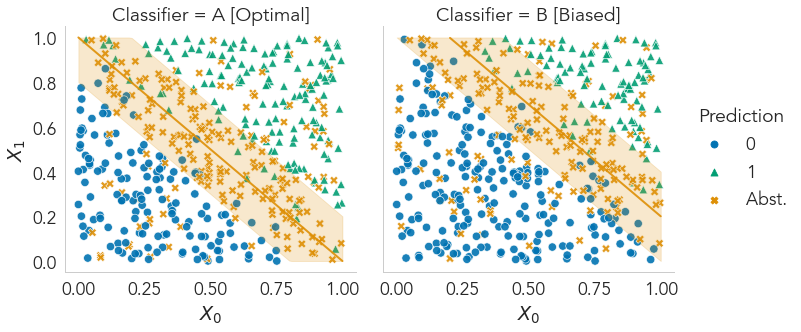

In [27]:
colors = {
    "predict_0": palette[0],
    "predict_1": palette[2],
    "abstain": palette[1],
    "boundary": palette[1],
}

fg = sns.relplot(
    x=r"$X_0$",
    y=r"$X_1$",
    col="Classifier",
    # colors
    hue="Prediction",
    hue_order=["0", "1", "Abst."],
    palette=[colors["predict_0"], colors["predict_1"], colors["abstain"]],
    alpha=0.9,
    # markers
    style="Prediction",
    style_order=["0", "1", "Abst."],
    markers=['o', '^', 'X'],
#     style=r"$Y$",
#     style_order=[0, 1],
#     markers=['o', '^'],
    data=data.iloc[print_index],
    s=70,
)
for ax in fg.axes[0]:
    ax.grid()

x0 = np.linspace(0, 1, 100)

# A boundary & abstention regions
x1_a = 1 - x0
fg.axes[0, 0].plot(x0, x1_a, linewidth=2, alpha=0.9, color=colors["boundary"])
thres_a = threshold
fg.axes[0, 0].fill_between(
    x=x0,
    y1=np.maximum(0, x1_a - thres_a),
    y2=np.minimum(1, x1_a + thres_a),
    alpha=0.2,
    color=colors["boundary"],
)

# B boundary & abstention regions
x1_b = 1 + power_mu - x0
mask_b = x1_b <= 1
fg.axes[0, 1].plot(x0[mask_b], x1_b[mask_b], 
                   linewidth=2, alpha=0.9, color=colors["boundary"])
thres_b = threshold
fg.axes[0, 1].fill_between(
    x=x0,
    y1=np.maximum(0, x1_b - thres_b),
    y2=np.minimum(1, x1_b + thres_b),
    alpha=0.2,
    color=colors["boundary"],
)

# legend setup
sns.move_legend(fg, "center right", bbox_to_anchor=(0.99, 0.52), frameon=False)
# sns.move_legend(fg, loc="lower center", bbox_to_anchor=(0.45, -0.15),
#                 frameon=True, ncol=4)
for lh in fg._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [50] 
fg.tight_layout()
fg.savefig(os.path.join(PLOTS_DIR, "classifiers_power.pdf"))
None

## Power Experiment

In [28]:
power_df = pd.read_csv("./plots/binary_mar/experiment2/zero_one/eps0.2/power.csv", index_col=0)

In [29]:
# selection
power_df = power_df.query("n > 200 & Learner == 'SuperLearner'")

In [30]:
# use Delta values (TODO: replace with saved values)
if "Delta" not in power_df:
    power_df["Delta"] = 0.0
    for mu, delta in [
        (0, 0),
        (0.05, 0.045),
        (0.10, 0.069),
        (0.15, 0.088),
        (0.20, 0.123),
        (0.25, 0.152),
        (0.30, 0.180),
        (0.35, 0.181),
        (0.40, 0.219),
        (0.45, 0.248),
        (0.50, 0.271),
    ]:
        power_df.loc[power_df["mu"] == mu, "Delta"] = delta

power_df

,Estimator,Learner,Rejection,Miscoverage,n,mu,Delta
111000,DR,SuperLearner,False,False,400,0.0,0.000
111001,DR,SuperLearner,False,False,400,0.0,0.000
111002,DR,SuperLearner,False,False,400,0.0,0.000
111003,DR,SuperLearner,False,False,400,0.0,0.000
111004,DR,SuperLearner,False,False,400,0.0,0.000
...,...,...,...,...,...,...,...
164995,DR,SuperLearner,True,False,3200,0.5,0.271
164996,DR,SuperLearner,True,False,3200,0.5,0.271
164997,DR,SuperLearner,True,False,3200,0.5,0.271
164998,DR,SuperLearner,True,False,3200,0.5,0.271


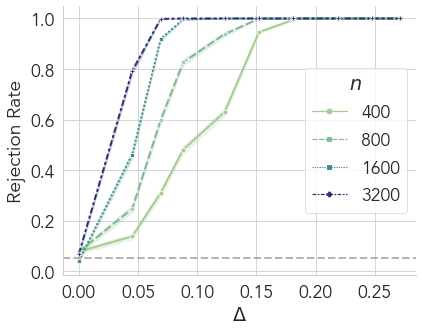

In [31]:
power_df = power_df.rename(columns={
    "Delta": r"$\Delta$", "mu": r"$\mu$", 
    "n": r"$n$", 
    "Rejection": "Rejection Rate",
    "Miscoverage": "Miscoverage Rate",
})

fg = sns.relplot(
    x=r"$\Delta$",
    # x=r"$\mu$",
    y="Rejection Rate",
    hue=r"$n$",
    style=r"$n$",
    #col="Learner",
    kind="line",
    linewidth=2,
    markers=True,
    errorbar="se",
    palette="crest",
    data=power_df,
    aspect=1.25,
    facet_kws={"legend_out": False},
)
fg.axes[0, 0].axhline(y=0.05, alpha=0.7, linewidth=2, linestyle="--",
                      color=cc.get_color_by_index(7))
# sns.move_legend(fg, "center", bbox_to_anchor=(0.45, 0.55))
fg.savefig(os.path.join(PLOTS_DIR, "power.pdf"))

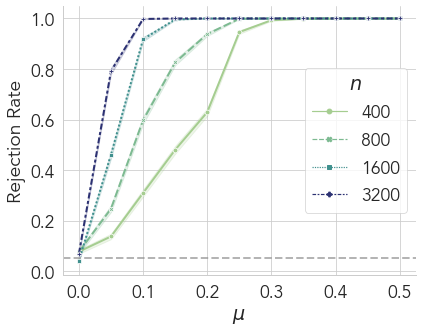

In [32]:
# by mu
fg = sns.relplot(
    x=r"$\mu$",
    y="Rejection Rate",
    hue=r"$n$",
    style=r"$n$",
    #col="Learner",
    kind="line",
    linewidth=2,
    markers=True,
    errorbar="se",
    palette="crest",
    data=power_df,
    aspect=1.25,
    facet_kws={"legend_out": False},
)
fg.axes[0, 0].axhline(y=0.05, alpha=0.7, linewidth=2, linestyle="--",
                      color=cc.get_color_by_index(7))
# sns.move_legend(fg, "center", bbox_to_anchor=(0.45, 0.55))
fg.savefig(os.path.join(PLOTS_DIR, "power_mu.pdf"))